In [747]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
import matplotlib.ticker as ticker
from tqdm import tqdm
from numba import njit

def add_periodic_boundaries(arr):
    # takes an (n-2, m-2) array and returns (n, m) array
    rows, cols = arr.shape
    output = np.zeros((rows+2, cols+2), dtype=arr.dtype)

    # Fill the output array with the periodic boundaries
    output[1:-1, 1:-1] = arr # center
    output[0:1, 1:-1] = arr[-1:,:] # first row
    output[-1:, 1:-1] = arr[0:1,:] # last row
    output[1:-1, 0:1] = arr[:,-1:] # first column
    output[1:-1, -1:] = arr[:,0:1] # last column

    return output

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Random initialization

In [806]:
np.random.seed(42)

### 1.1 
n, m = 45, 53 # dimension of the grid
T = 300 # time steps

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited_spectrum = [1]
refractor = excited_spectrum[-1] + 1

@njit
def excite(s_prev, 
           rest=rest, 
           excited=excited_spectrum[0]): 
    # rest -> excited according to von Neumann neighborhood condition
    # by default the ground state is excited
    
    s_next = np.infty * np.ones_like(s_prev)
    for i in range(1, n+1): # n + 2 = include infinity, n + 1 = include periodic boundary
        for j in range(1, m+1):
            if s_prev[i, j] == rest:
                # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
                # This occurs for the previous state
                neighborhood = np.array([
                    s_prev[i-1, j], s_prev[i, j-1], s_prev[i, j+1], s_prev[i+1, j]
                ])
                
                # Checks if there is at least one excited state in the neighbor. 
                if np.sum(neighborhood == excited) >= 1:
                    s_next[i, j] = excited
                else:
                    s_next[i, j] = rest
            else:
                s_next[i, j] = s_prev[i, j]
    return s_next

def time_evolution(s_initial): 
    """
    Takes some initial configuration (s_initial) and returns the time evolution 
    of the system (results) until some periodic oscillation occurs.
    """
    results = np.zeros([T, n+2, m+2])
    prev_states = []

    ### 1.2 and 3
    # Loop for time evolution of the system
    for t in tqdm(range(T)):
        results[t] = s_initial
        prev_states.append(s_initial)
        
        # excitation 
        s_next = excite(s_initial)
        
        # unconditional transition
        # excluding the last element since the transition must correspond to last excited -> refractor
        for prev_state, next_state in zip(
            excited_spectrum[:-1], 
            np.roll(excited_spectrum, shift=-1)[:-1]):
            
            s_next[s_initial == prev_state] = next_state # updating the excited states
        
        s_next[s_initial == excited_spectrum[-1]] = refractor # last excited state -> refractor
        s_next[s_initial == refractor] = rest # refractor -> rest
        s_initial = s_next # update s_initial to be the evolved state
        
        # Check for periodicity
        for i, prev_state in enumerate(prev_states):
            if np.allclose(s_next, prev_state):
                periodicity = t - i + 1
                print(f"At transient time t={t+1}, the system reached a periodic state with {periodicity=}.")
                break
        else:
            continue

        break

    return results[:(t+1)]

                
# initial state, the boundaries are padded with infinities
s1 = np.infty * np.ones([n+2,m+2]) # add 2 because the extra correspond to infinity boundary
s1[1:-1,1:-1] = add_periodic_boundaries(
    np.random.choice([rest] + excited_spectrum + [refractor], 
                     size=[n-2, m-2], # subtracting 2 because of periodic boundaries is adding 2
                     p=(refractor+1) * [1/(refractor+1)] # default to be uniform distributed
    ) 
)

s2 = s1.copy()
s2[n//2, m//2] = (s1[n//2, m//2] + 1) % 2 # shifts the values for a cell

results1 = time_evolution(s1)
results2 = time_evolution(s2)

 14%|█▎        | 41/300 [00:00<00:02, 99.83it/s] 


At transient time t=42, the system reached a periodic state with periodicity=3.


 14%|█▎        | 41/300 [00:00<00:00, 378.54it/s]

At transient time t=42, the system reached a periodic state with periodicity=3.


# Custom initialization

In [676]:
def generate_matrices():
    matrices = []

    for a in range(3):
        for b in range(3):
            for c in range(3):
                for d in range(3):
                    matrix = np.array([[a, b], [c, d]])
                    matrices.append(matrix)

    return matrices

def filter_matrices(matrices, a, b, c):
    filtered_matrices = []

    for matrix in matrices:
        # Check horizontal and vertical neighbors
        neighbors = (matrix[0, 0] == a and matrix[0, 1] == a) or \
                    (matrix[1, 0] == a and matrix[1, 1] == a) or \
                    (matrix[0, 0] == a and matrix[1, 0] == a) or \
                    (matrix[0, 1] == a and matrix[1, 1] == a)

        # Check if the matrix contains b and c
        contains_b_and_c = (b in matrix.flatten()) and (c in matrix.flatten())

        if neighbors and contains_b_and_c:
            filtered_matrices.append(matrix)

    return filtered_matrices

matrices = generate_matrices()
matrices0012 = filter_matrices(matrices, 0, 1, 2)
matrices0112 = filter_matrices(matrices, 1, 0, 2)
matrices0122 = filter_matrices(matrices, 2, 1, 0)

In [713]:
initial_config = np.concatenate(matrices0012 + matrices0112 + matrices0122, 0) # definately works
initial_config = initial_config.reshape(12, 8)
n, m = initial_config.shape

s0 = np.infty * np.ones([n+2,m+2])
s0[1:-1,1:-1] = initial_config 

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited_spectrum = [1]
refractor = excited_spectrum[-1] + 1

T = 100 # time steps
results = np.infty * np.ones([T, n+2, m+2])
prev_states = []

@njit
def excite(s0, 
           rest=rest, 
           excited=excited_spectrum[0]): 
           # rest -> excited according to some condition
           # by default the ground state is excited
    
    s1 = np.infty * np.ones_like(s0)
    for i in range(1, n+1): # n + 2 = include infinity, n + 1 = include periodic boundary
        for j in range(1, m+1):
            if s0[i, j] == rest:
                # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
                # This occurs for the previous state
                neighborhood = np.array([
                    s0[i-1, j], s0[i, j-1], s0[i, j+1], s0[i+1, j]
                ])
                
                # Checks if there is at least one excited state in the neighbor. 
                if np.sum(neighborhood == excited) >= 1:
                    s1[i, j] = excited
                else:
                    s1[i, j] = rest
            else:
                s1[i, j] = s0[i, j]
    return s1


### 1.2 and 3
# Loop for time evolution of the system
for t in tqdm(range(T)):
    results[t] = s0
    prev_states.append(s0)
    
    # excitation with some condition
    s1 = excite(s0)
    
    # unconditional transition
    # excluding the last element since the transition must correspond to last excited -> refractor
    for prev_state, next_state in zip(
        excited_spectrum[:-1], 
        np.roll(excited_spectrum, shift=-1)[:-1]):
        
        s1[s0 == prev_state] = next_state # updating the excited states
    
    s1[s0 == excited_spectrum[-1]] = refractor # last excited state -> refractor
    s1[s0 == refractor] = rest # refractor -> rest
    s0 = s1 # s0 is now the evolved state
    
    # Check for periodicity
    for i, prev_state in enumerate(prev_states):
        if np.allclose(s1, prev_state):
            periodicity = t - i + 1
            print(f"At transient time t={t+1}, the system reached a periodic state with {periodicity=}.")
            break
    else:
        continue

    break
    
results = results[:(t+1)]

 13%|█▎        | 13/100 [00:00<00:02, 41.45it/s]

At transient time t=14, the system reached a periodic state with periodicity=3.


# Visualizations

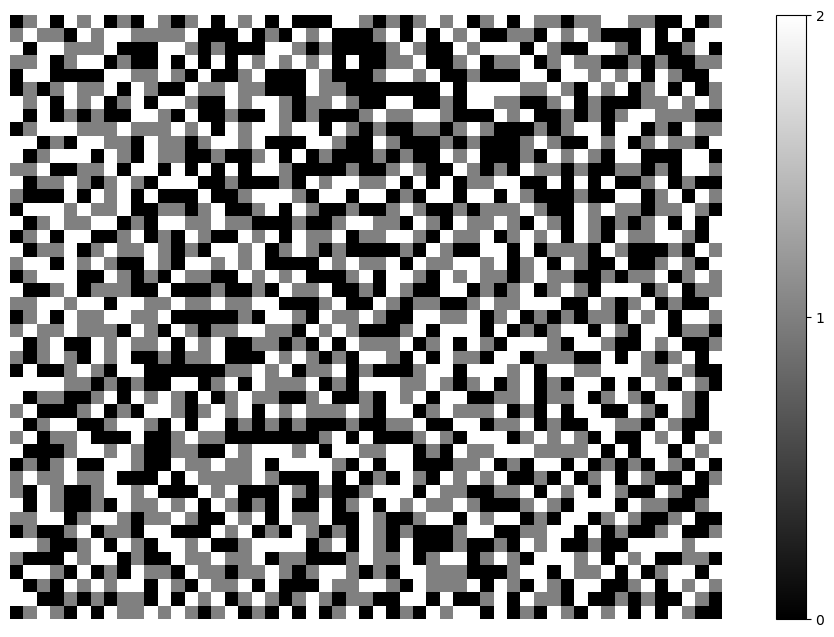

In [807]:
plt.imshow(results1[13][1:-1,1:-1], vmin=0, vmax=refractor)  
plt.colorbar(ticks=[rest] + excited_spectrum + [refractor])
plt.axis("off")
plt.show()

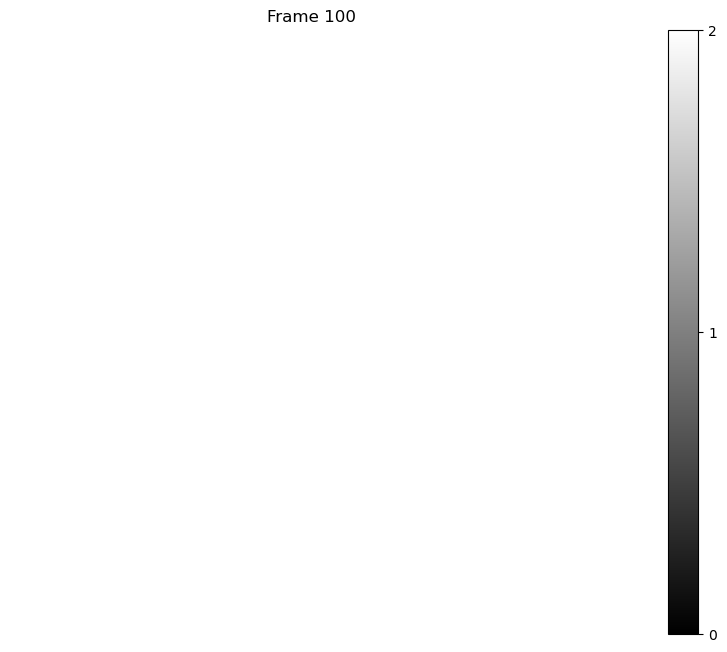

In [681]:
def update_plot(i, im, results):
    im.set_array(results[i][1:-1,1:-1])
    plt.title('Frame {}'.format(i+1))
    return [im]

def create_gif(results, filename, duration=100):
    fig = plt.figure()
    im = plt.imshow(results[-1], animated=True, vmin=0, vmax=refractor)
    cbar = plt.colorbar(ticks=[rest] + excited_spectrum + [refractor])
    plt.axis("off")

    ani = FuncAnimation(fig, update_plot, frames=range(T), 
                        fargs=(im, results), interval=duration, blit=True)
    ani.save(filename, writer='pillow', fps=1)

create_gif(results, 'GHCA.gif', duration=100)

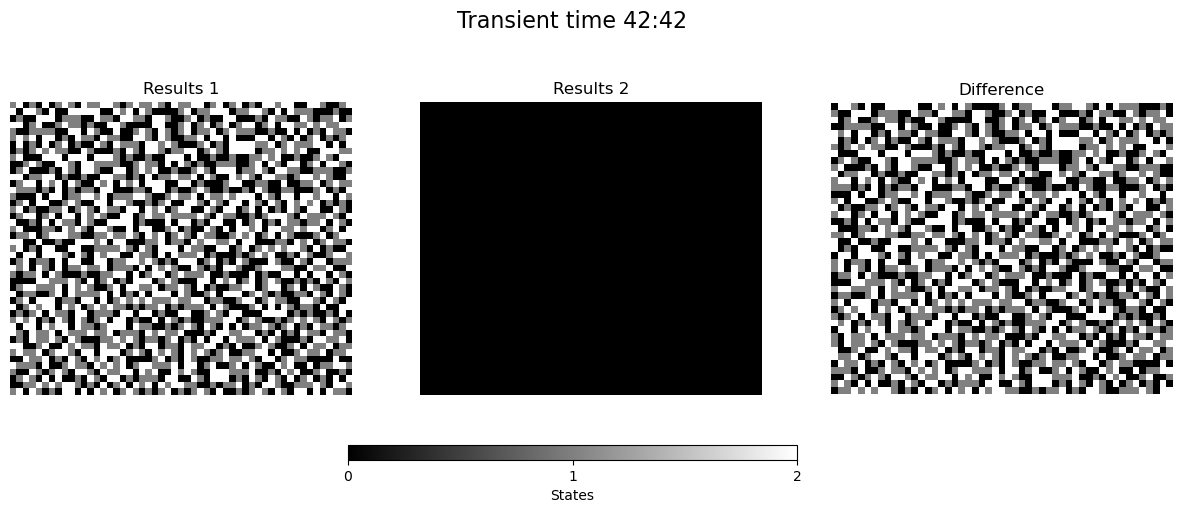

In [818]:
def update_plot(i, ims, results1, results2, diff_results, fig):
    ims[0].set_array(results1[i][1:-1,1:-1])
    ims[1].set_array(results2[i][1:-1,1:-1])
    ims[2].set_array(diff_results[i][1:-1,1:-1])
    fig.suptitle(f'Transient time {i+1}:{len(results1)}', fontsize=16)
    return ims

def create_side_by_side_gif(results1, results2=None, filename='GHCA.gif', duration=100):
    if results2 is None:
        results2 = np.zeros_like(results1)

    T = results1.shape[0]
    diff_results = np.abs(results1[:T,1:-1,1:-1] - results2[:T,1:-1,1:-1])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    ims = [axes[0].imshow(results1[-1], animated=True, vmin=0, vmax=refractor),
           axes[1].imshow(results2[-1], animated=True, vmin=0, vmax=refractor),
           axes[2].imshow(diff_results[-1], animated=True)]

    for ax, title in zip(axes, ['Results 1', 'Results 2', 'Difference']):
        ax.set_title(title)
        ax.axis("off")

    # Add a horizontal colorbar at the bottom
    cbar_ax = fig.add_axes([0.35, 0.08, 0.3, 0.03])
    cbar = fig.colorbar(ims[0], cax=cbar_ax, ticks=[rest] + excited_spectrum + [refractor], orientation='horizontal')
    cbar.set_label("States")

    ani = FuncAnimation(fig, update_plot, frames=range(T), 
                        fargs=(ims, results1, results2, diff_results, fig), 
                        interval=duration, blit=True)
    ani.save(filename, writer='pillow', fps=1)

# Example usage with only one set of results (results1)
create_side_by_side_gif(results1, duration=100)
